In [1]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
from tensorflow import keras
import numpy as np
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [2]:
def filenames(part,train=True):
    root='../input/mura-v11/'
    if train:
        csv_path="../input/mura-v11/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="../input/mura-v11/MURA-v1.1/valid_image_paths.csv"
    
    with open(csv_path, 'rb') as F:
        d = F.readlines()
#         print(str(d[0],encoding='utf-8').strip())
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d]  # 所有图片的存储路径, [:-1]目的是抛弃最末尾的\n
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

#     imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
#     print("self testing:",imgs[:5],labels[:5])
    return imgs,labels

In [3]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [4]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)
# from albumentations.augmentations.transforms import Resize
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])
AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [5]:
albumentation_list =  [
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
]
root='../input/mura-v11/'
chosen_image= imread(root+'MURA-v1.1/train/XR_ELBOW/patient01055/study1_positive/image3.png')
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)
img= resize(chosen_image,(300,300,3))
img_matrix_list.append(img)
img_matrix_list.append(crop_center(img,224,224))

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
               "Shift Scale Rotate","Resizing", "Cropping"]

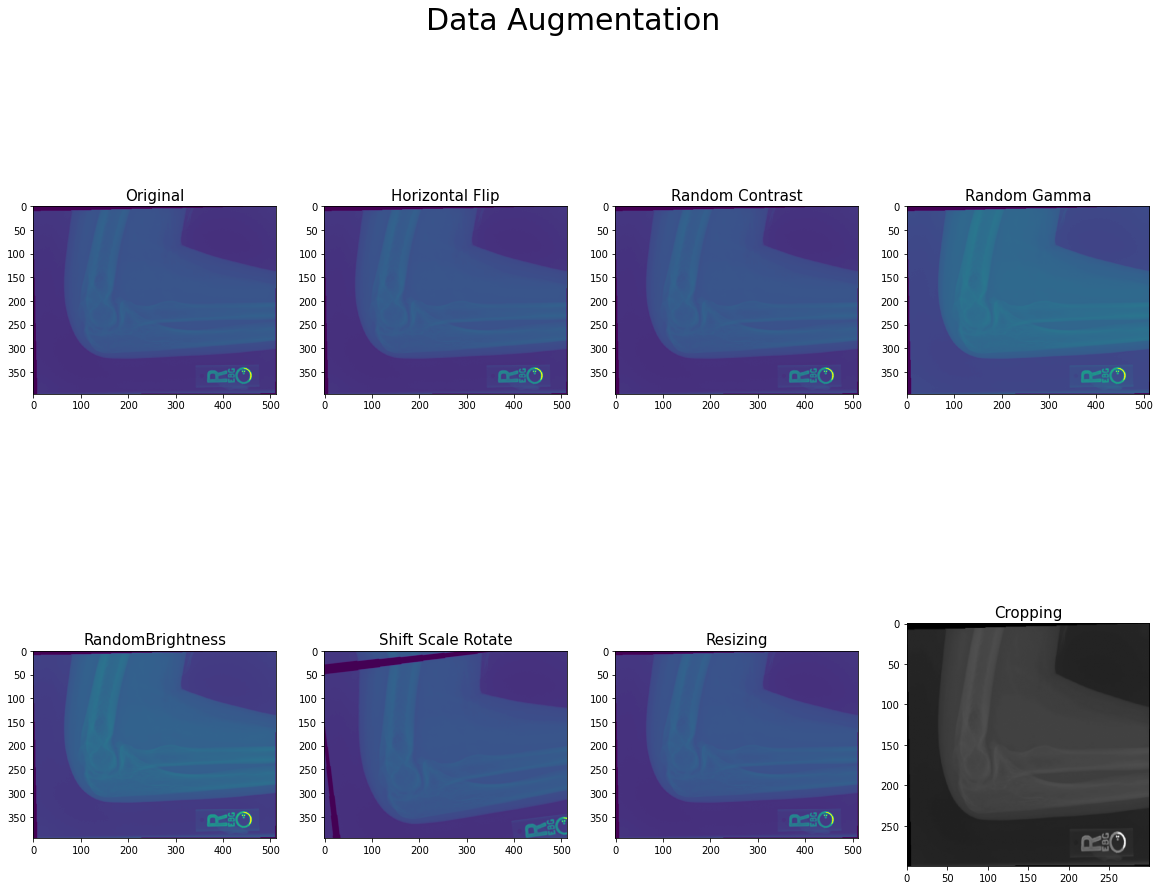

In [6]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize = 30)
    #fig.subplots_adjust(wspace=0.3)
    #fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_multiple_img(img_matrix_list, titles_list, ncols = 4)


In [7]:
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames, labels, batch_size,transform) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.t= transform
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        x=[]
        for file in batch_x:
            img= imread(file)
            img= self.t(image=img)["image"]
            img= resize(img,(300,300,3))
            img= crop_center(img,224,224)
            x.append(img)
        x=np.array(x)/255.0
        y= np.array(batch_y)
        return x,y

In [8]:
part='XR_FINGER'
imgs,labels= filenames(part=part)
vimgs,vlabels= filenames(part=part,train=False)
print(labels.count('positive'),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print("Training Data: ", training_data)
y_data= [0 if x=='positive' else 1 for x in labels]
# print(y_data[-1:-5:-1])
y_data= keras.utils.to_categorical(y_data)
# print(y_data[-1:-5:-1])
print(vlabels.count('positive'),vlabels.count('negative'))
validation_data= vlabels.count('positive')+vlabels.count('negative')
print("Validation Data: ", validation_data)
vy_data= [0 if x=='positive' else 1 for x in vlabels]
vy_data= keras.utils.to_categorical(vy_data)

1968 3138
Training Data:  5106
247 214
Validation Data:  461


In [9]:
# np.argmax(y_data,axis=1)

In [10]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_data, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

In [11]:
batch_size = 32
imgs, y_data = shuffle(imgs, y_data)
#vimgs, vy_data = shuffle(vimgs, vy_data)
my_training_batch_generator = My_Custom_Generator(imgs, y_data, batch_size,AUGMENTATIONS_TRAIN)
my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

In [12]:
part='XR_FINGER'
checkpoint_path = "FINGER_MODEL.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True,
                                       save_weights_only=False, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3,
                                         min_delta=0.001, verbose=1, min_lr=0.000000001)]

In [13]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [14]:
# with tpu_strategy.scope():
Inception=tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x=Inception (input_image)

x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Flatten()(x)

x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x=keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)


model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

print(model.summary())

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation_94 (Activation)   (None, 256)               0         
______________________________________________________________

In [15]:
my_callbacks,d_class_weights

([<tensorflow.python.keras.callbacks.ModelCheckpoint at 0x7a88f49b5b10>,
 {0: 1.2972560975609757, 1: 0.8135755258126195})

In [16]:
history=model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 18,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(validation_data // batch_size),
                   callbacks=my_callbacks)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/18
159/159 [==============================] - 380s 2s/step - loss: 0.6352 - accuracy: 0.6601 - val_loss: 2.3604 - val_accuracy: 0.4487
Epoch 2/18
159/159 [==============================] - 314s 2s/step - loss: 0.5050 - accuracy: 0.7422 - val_loss: 0.7843 - val_accuracy: 0.4643
Epoch 3/18
159/159 [==============================] - 311s 2s/step - loss: 0.4575 - accuracy: 0.7826 - val_loss: 1.5283 - val_accuracy: 0.5491
Epoch 4/18
159/159 [==============================] - 308s 2s/step - loss: 0.4545 - accuracy: 0.8018 - val_loss: 0.7925 - val_accuracy: 0.7344
Epoch 5/18
159/159 [==============================] - 311s 2s/step - loss: 0.3823 - accuracy: 0.8322 - val_loss: 2.1462 - val_accuracy: 0.7165
Epoch 6/18
159/159 [==============================] - 310s 2s/step - loss: 0.3568 - accuracy: 0.8465 - val_loss: 1.6516 - val_accuracy: 0.7366
Epoch 7/18
159/159 [==============================] - 309s 2s/step - loss: 0.3369 - accuracy: 0.8562 - val_loss: 6.1832 - val_accuracy: 0.6696